In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import pandas as pd
import multiprocessing as mp
import time

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [2]:
def pt(x, y, t):
    r = np.ceil(8. * t)
    xy = x - y
    z = np.arange(-r, r+1)
    z = np.array(np.meshgrid(z, z))[None,None,...]
    xy = xy.reshape((*xy.shape, 1, 1))
    a = np.linalg.norm(xy + z, axis=-3)**2 / 2
    res = 1. / (2 * np.pi * t**2) * np.sum(np.exp(-a / t**2), axis=(-1,-2))
    return res

def sample(gen, M, t):
    X = gen.random((M,2))
    Y = (X + gen.normal(0, t, size=(M,2))) % 1
    return X.reshape((M, 1, 2)), Y.reshape((1, M, 2))

def f(X, Y, t):
    return np.sum(np.log(np.mean(pt(X, Y, t), axis=1)))

def f_multi(Xs, Ys, t):
    return np.sum([f(X, Y, t) for X, Y in zip(Xs, Ys)])

def sample_multi(gen, N, M, t):
    Xs, Ys = [], []
    for _ in range(N):
        X, Y = sample(gen, M, t)
        Xs += [X]
        Ys += [Y]
    return Xs, Ys

In [5]:
M = 100
N = 10
    
tt = [0.01, 0.05, 0.1, 0.2]


ts = np.linspace(0.001, 0.5, 1000)

data = []

t0 = time.time()
for t in tt:
    seed = np.random.SeedSequence(42)
    gen = np.random.Generator(np.random.PCG64(seed))
    
    Xs, Ys = sample_multi(gen, N, M, t)
    
    
    def h(x):
        return f_multi(Xs, Ys, x)
    
    with mp.Pool(16) as pool:
        fs = pool.map(h, ts)
    #fs = [h(x) for x in ts]
    
    data += [{"Xs" : Xs, "Ys" : Ys, "t" : t, "ts" : ts, "fs" : fs}]

t1 = time.time()
print(f"{t1-t0}s")

/tmp/ipykernel_2342045/1615559795.py:17: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(np.mean(pt(X, Y, t), axis=1)))
/tmp/ipykernel_2342045/1615559795.py:17: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(np.mean(pt(X, Y, t), axis=1)))
/tmp/ipykernel_2342045/1615559795.py:17: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(np.mean(pt(X, Y, t), axis=1)))


217.700590133667s


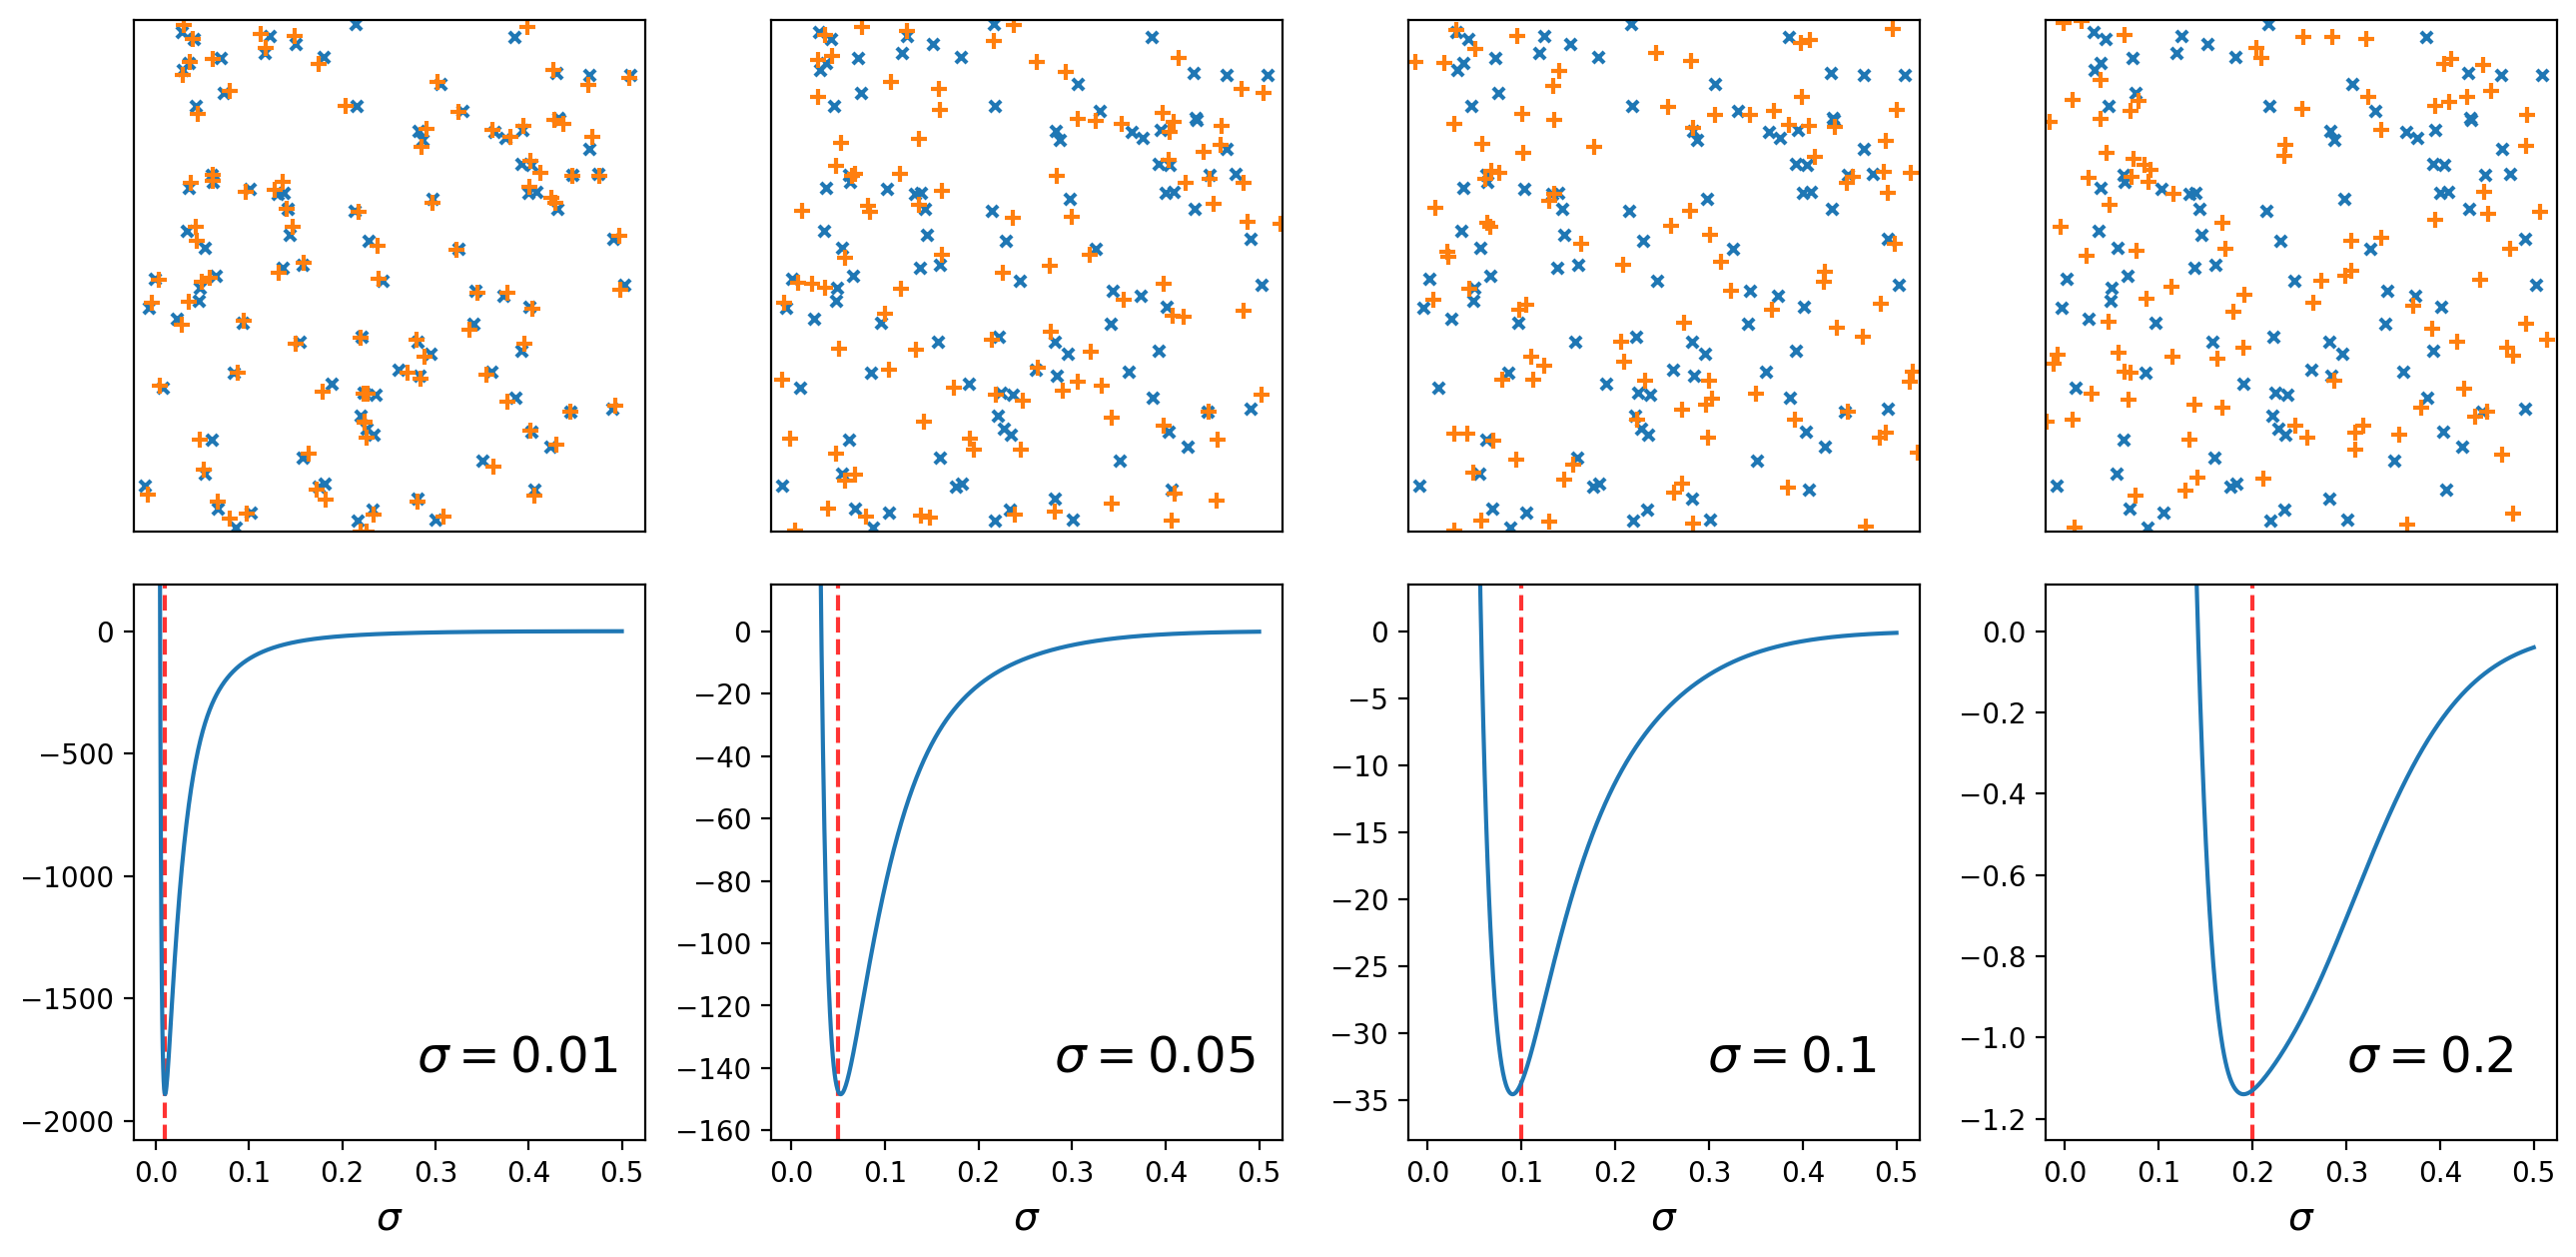

In [6]:
fig, axs = plt.subplots(2, 4, figsize=(13,6.5), dpi=200)

#fig.suptitle(f"M = {M}, N = {N}")

for i, d in enumerate(data):

    Xs = d['Xs']
    Ys = d['Ys']
    ts = d['ts']
    fs = d['fs']
    t = d['t']
    
    #axs[0,i].set_title(f"$\sigma = {t}$")
    
    axs[0,i].scatter(Xs[0][:,:,0], Xs[0][:,:,1], s=16, marker='x')
    axs[0,i].scatter(Ys[0][:,:,0], Ys[0][:,:,1], marker='+')
    axs[0,i].set_aspect(1)
    axs[0,i].set_xlim(0,1)
    axs[0,i].set_ylim(0,1)
    axs[0,i].set_xticks([])
    axs[0,i].set_yticks([])

    axs[1,i].plot(ts, -np.array(fs))
    
    axs[1,i].text(0.75, 0.15, f"$\sigma={t}$", 
                  horizontalalignment='center',
                  verticalalignment='center',
                  transform=axs[1,i].transAxes,
                  fontsize=18)
    
    yl = [-np.max(fs), 0]
    yl = [yl[0] - 0.1 * (yl[1] - yl[0]), yl[1] + 0.1 * (yl[1] - yl[0])]
    
    axs[1,i].plot([t,t], np.array(yl), color="red", zorder=-1, linestyle="dashed", alpha=0.8)
    
    axs[1,i].set_ylim(yl[0], yl[1])
    axs[1,i].set_xlabel("$\sigma$", fontsize=14)

axs[1,0].set_ylabel("")
plt.tight_layout()
plt.show()